In [1]:
%load_ext autoreload
%autoreload 2


from pathlib import Path

import cv2
import glasbey
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from pynodal_decomposition.graph import (
    build_neighbor_over_perimeter_adjancency_matrix,
    merge_louvain_communities,
)
from pynodal_decomposition.io import read_img, resize_img
from pynodal_decomposition.plot import imshow
from pynodal_decomposition.segment import (
    fuse_inner_segments,
    get_mask,
    get_segment,
    merge_segments_from_circular_mask,
    preprocess,
    remove_disconnected_elements,
)

palette = glasbey.extend_palette("tab20c", palette_size=64)

cmap = matplotlib.colors.ListedColormap(palette)


In [2]:
from tqdm.contrib.concurrent import process_map

/home/clement/miniforge-pypy3/envs/test/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


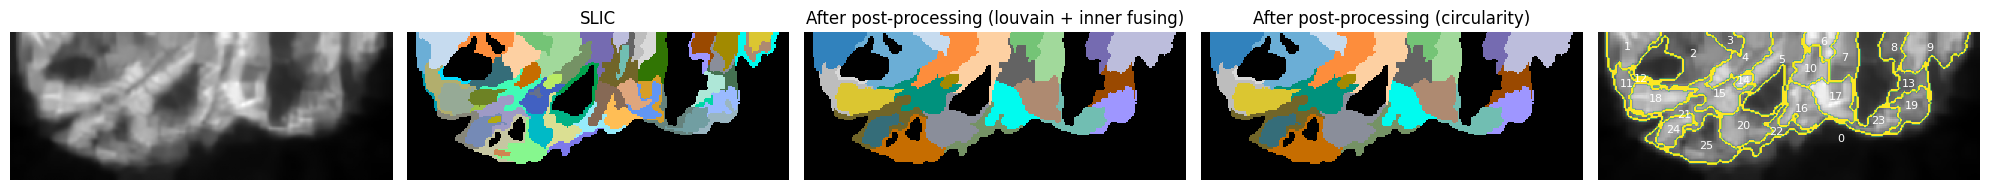

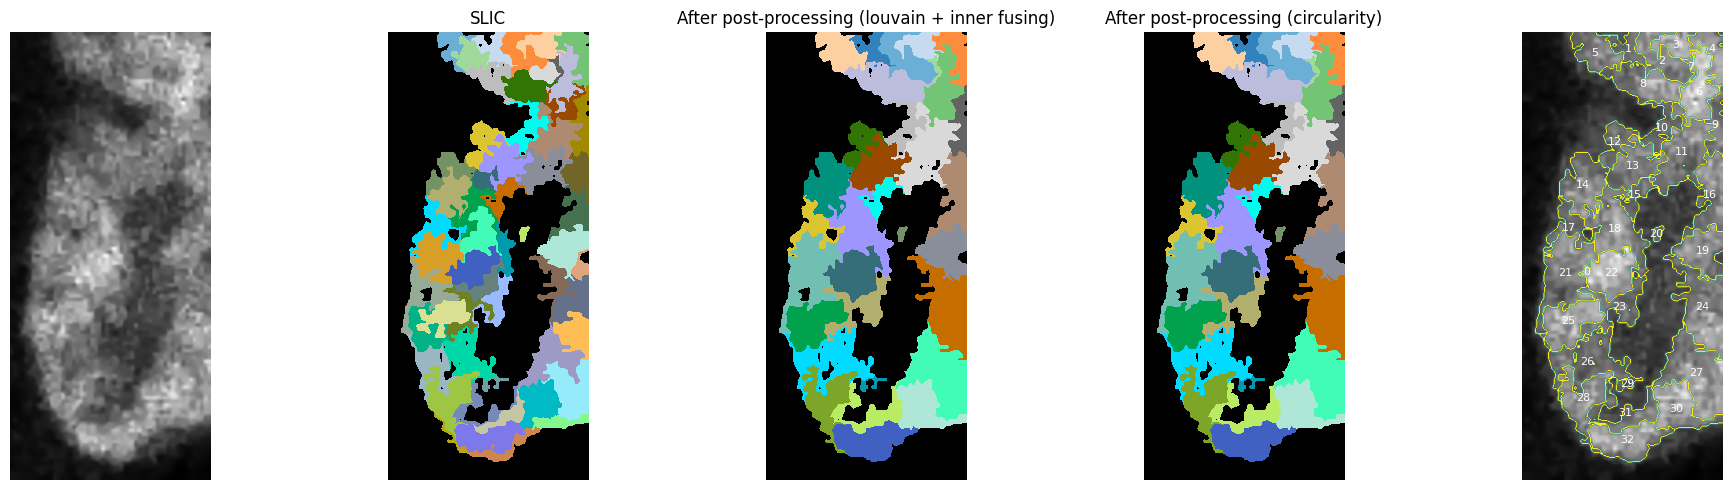

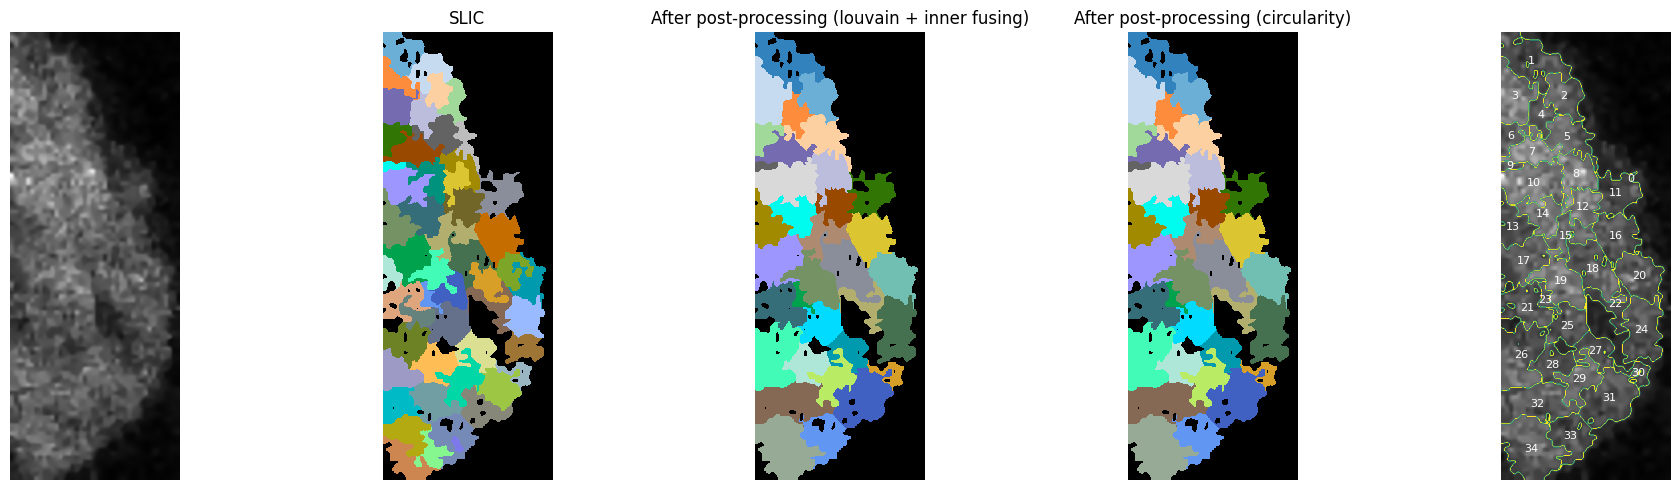

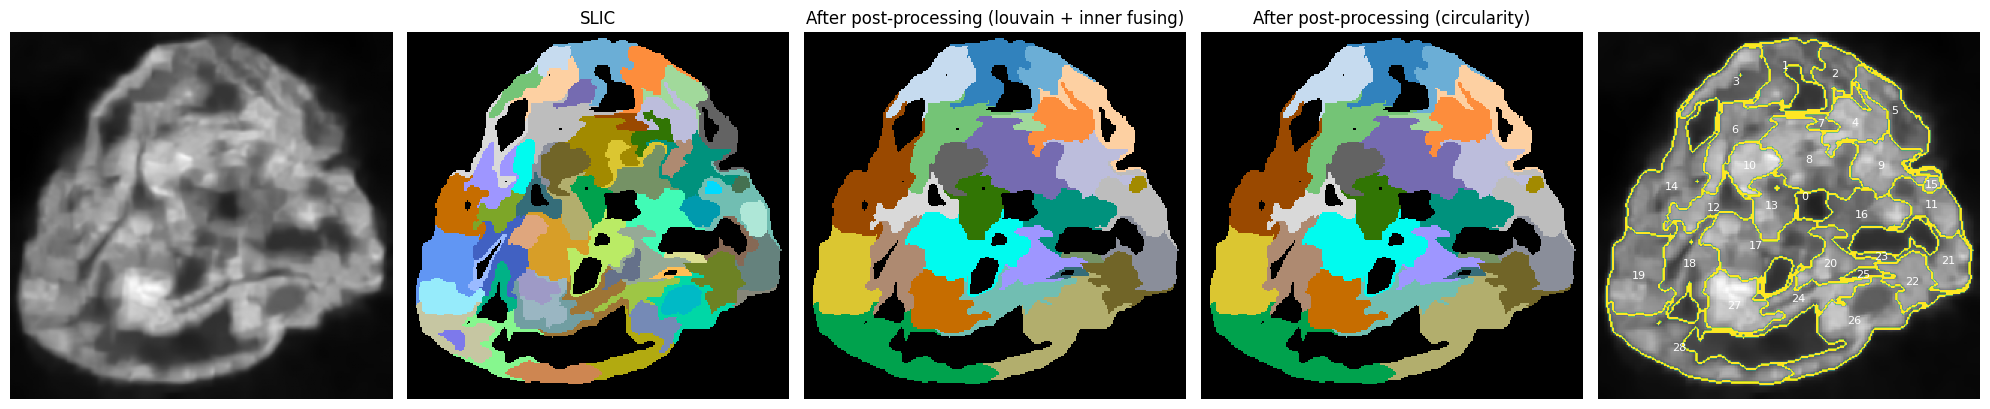

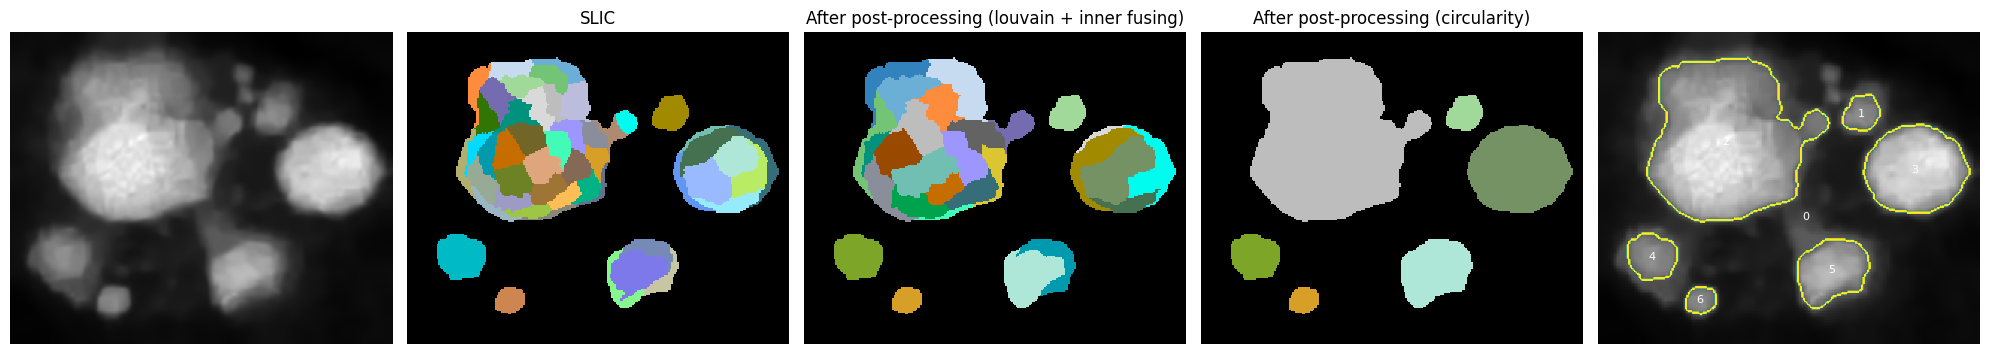

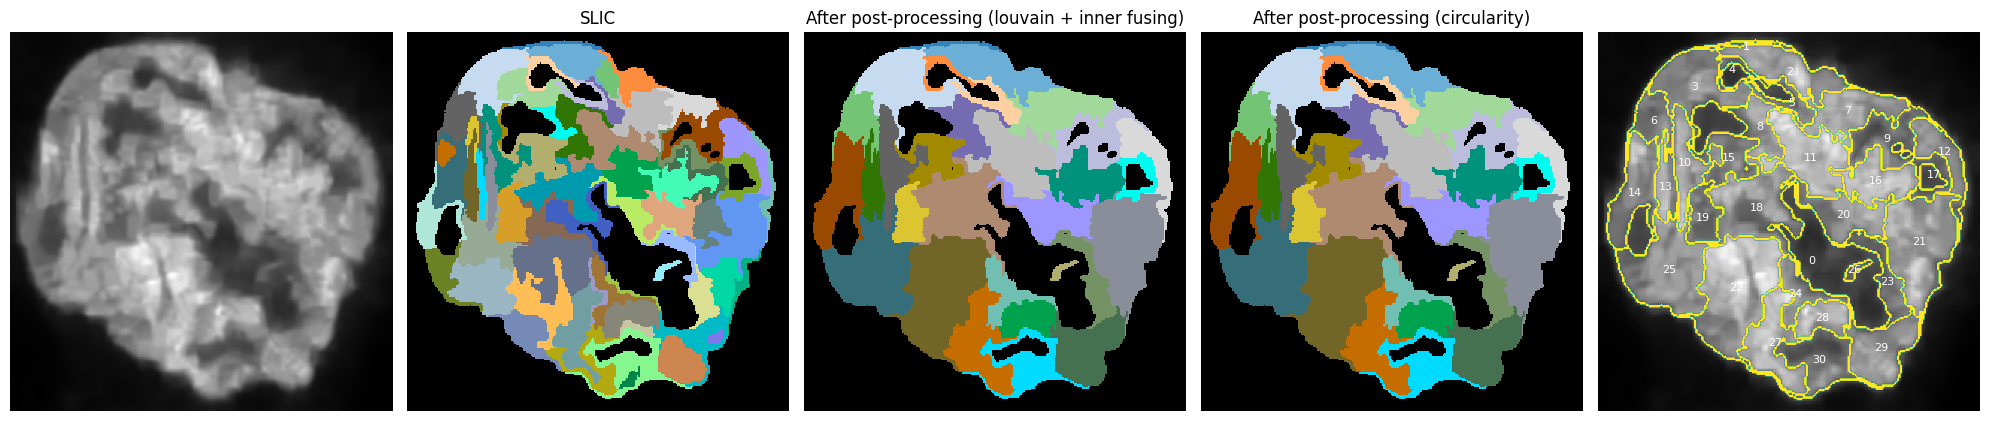

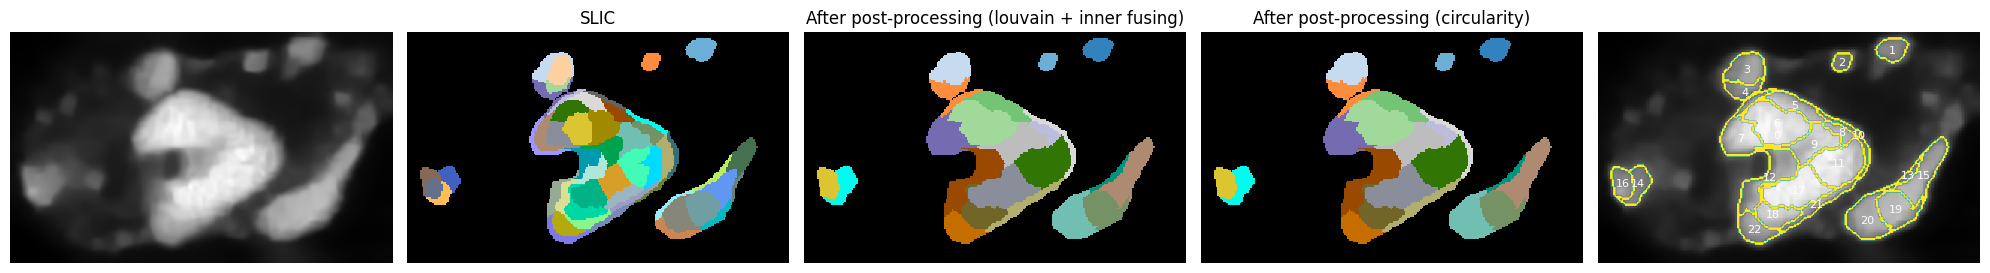

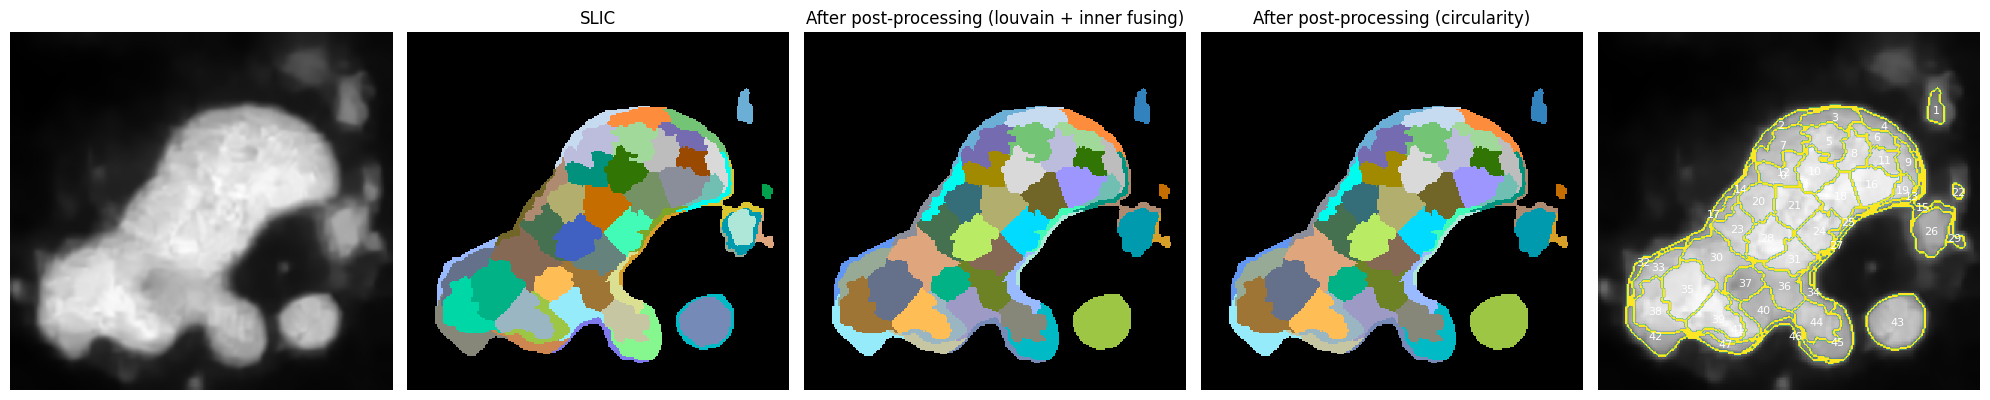

In [3]:
root = Path("/home/clement/Documents/data/SpinodalDecomposition/ori_tif/")
output_folder = Path("../result/output_SLIC_and_PostProcess_circularity/")
output_folder.mkdir(exist_ok=True, parents=True)

all_files = list(root.glob("*.tif"))
all_files = sorted(all_files)


def process_file(file, show=False, save=True):
    if save and (output_folder / f"{file.stem}.png").exists():
        return
    img = read_img(file)
    h, w, _ = img.shape
    img = resize_img(img, 256)
    img = preprocess(img, 0.1)
    mask = 1 - get_mask(img, method="otsu")

    segment = get_segment(
        img,
        "slic",
        n_segments=48,
        compactness=10,
        min_size_factor=0.1,
        enforce_connectivity=True,
        # max_size_factor=1.0,
        mask=mask,
        sigma=0,
    )
    max_segment = segment.max()

    before = segment.copy()
    for i in range(1):
        segment = fuse_inner_segments(segment)
        adj_perimeter = build_neighbor_over_perimeter_adjancency_matrix(segment)
        segment = merge_louvain_communities(segment, adj_perimeter, 5)
        segment = fuse_inner_segments(segment)

    segment = remove_disconnected_elements(segment)
    segment = segment.astype(np.uint8)

    corrected_circularity = merge_segments_from_circular_mask(segment.copy(), mask, 0.4)

    mask = (mask * (corrected_circularity != 0)).astype(np.float32)

    if save:
        segment = cv2.resize(corrected_circularity, (w, h), interpolation=cv2.INTER_NEAREST)
        cv2.imwrite(output_folder / f"{file.stem}.png", segment)
    if show:
        fig, axs = plt.subplots(1, 5, figsize=(20, 5))
        axs[0].imshow(img / 255.0, cmap="gray")
        axs[0].axis("off")

        axs[2].imshow(segment, cmap=cmap, interpolation="None", vmin=1, vmax=max_segment + 1)
        axs[2].imshow(mask, cmap="gray", interpolation="None", alpha=(1 - mask).astype(float))

        axs[2].title.set_text("After post-processing (louvain + inner fusing)")

        axs[2].axis("off")

        axs[3].imshow(corrected_circularity, cmap=cmap, interpolation="None", vmin=1, vmax=max_segment + 1)
        axs[3].imshow(mask, cmap="gray", interpolation="None", alpha=(1 - mask).astype(float))
        axs[3].title.set_text("After post-processing (circularity)")
        axs[3].axis("off")

        # segment = np.ma.masked_where(segment == 0, segment)
        axs[1].imshow(before, cmap=cmap, interpolation="None", vmin=0, vmax=max_segment + 1)

        axs[1].imshow(mask, cmap="gray", interpolation="None", alpha=(1 - mask).astype(float))

        axs[1].title.set_text("SLIC")

        axs[1].axis("off")

        imshow(img / 255.0, corrected_circularity, border_width=3, ax=axs[4], show_segment_id=True)
        plt.tight_layout()
        if save:
            fig.savefig(output_folder / f"{file.stem}.png", pad_inches=0, bbox_inches="tight")
        plt.show()
        plt.close(fig)

    # return fig, axs, segment

    # return img, segment


# process_map(process_file, all_files, max_workers=12, chunksize=100)
for i in np.arange(len(all_files))[:8]:
    process_file(all_files[i], show=True, save=False)